In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

In [31]:
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, classification_report, make_scorer
from numpy import mean, std
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.model_selection import cross_val_score, train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder

In [155]:
email_data = pd.read_csv('all_data.csv').drop('Unnamed: 0', axis = 1)

The EDA part of this data has already been done
We will move forward with the modeling part

In [6]:
le_et = LabelEncoder()
le_ev = LabelEncoder()
le_wd = LabelEncoder()
le_uc = LabelEncoder()


dummy = email_data.drop('email_id', axis = 1).copy()
dummy['email_text'] = le_et.fit_transform(dummy['email_text'])
dummy['email_version'] = le_ev.fit_transform(dummy['email_version'])
dummy['weekday'] = le_wd.fit_transform(dummy['weekday'])
dummy['user_country'] = le_uc.fit_transform(dummy['user_country'])


In [7]:
dummy.head()

,email_text,email_version,hour,weekday,user_country,user_past_purchases,Opened,Clicked
0,1,1,2,3,3,5,0,0
1,0,1,12,3,2,2,1,1
2,0,1,11,6,3,2,0,0
3,1,0,6,1,2,1,0,0
4,0,0,14,1,3,6,0,0


[Text(0.5, 0, 'email_text'),
 Text(1.5, 0, 'email_version'),
 Text(2.5, 0, 'hour'),
 Text(3.5, 0, 'weekday'),
 Text(4.5, 0, 'user_country'),
 Text(5.5, 0, 'user_past_purchases'),
 Text(6.5, 0, 'Opened'),
 Text(7.5, 0, 'Clicked')]

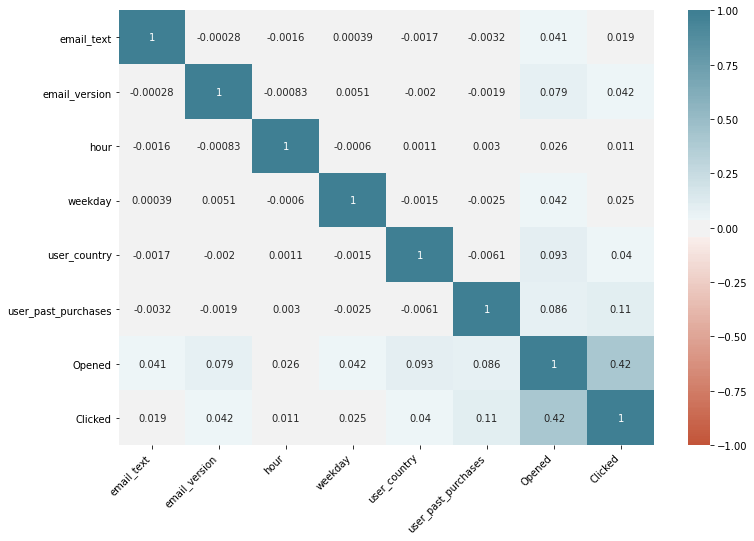

In [8]:
corr = dummy.corr()
plt.figure(figsize = (12, 8))
ax = sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200))
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')

good to go!

we will
1. Divide our data into features and target variables
2. Select an evaluation metric to choose from the models: in this case since both the false positive and true positives are important: we will use ROC AUC(class probabilities); for comparison we will use F1-Measure(class labels)
3. Define the evaluation method and score using the metrics
4. build a array of models to pass into this evalution methods and store the scores
5. Choose top 3-4 models and apply imbalance handling techniques
6. See the results (confusion matrix) and decide optimum threshold
7. further tune the models

In [5]:
data_dummy = pd.get_dummies(email_data.drop('email_id', axis = 1), drop_first = True).copy()
X = data_dummy.drop(['Opened', 'Clicked'], axis = 1)
y = data_dummy['Clicked']

In [10]:
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats=3, random_state = 0)
    score = cross_val_score(model, X, y, cv = cv, scoring = 'roc_auc', n_jobs = -1)
    return score

In [11]:
X.head()

,hour,user_past_purchases,email_text_short_email,email_version_personalized,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,user_country_FR,user_country_UK,user_country_US
0,2,5,1,1,0,0,1,0,0,0,0,0,1
1,12,2,0,1,0,0,1,0,0,0,0,1,0
2,11,2,0,1,0,0,0,0,0,1,0,0,1
3,6,1,1,0,1,0,0,0,0,0,0,1,0
4,14,6,0,0,1,0,0,0,0,0,0,0,1


In [12]:
# baseline model 
model = DummyClassifier(strategy='stratified')
scores = evaluate_model(X, y, model)

print("Mean score: ", mean(scores), "\n", "Std.dev: ", std(scores))

Mean score:  0.5007774371377713 
 Std.dev:  0.004457389427465452


In [60]:
def get_models():
    models, names = list(), list()
    #LogisticRegression
    models.append(LogisticRegression())
    names.append('LR')
    #balanced LR
    models.append(LogisticRegression(class_weight = 'balanced'))
    names.append('LR_bal')
    #SVM
    models.append(SVC(gamma = 'auto'))
    names.append('SVM')
    #KNN
    models.append(KNeighborsClassifier())
    names.append('KNN')
    #RF
    models.append(RandomForestClassifier(n_estimators = 100))
    names.append('RF')
    #ET
    models.append(ExtraTreesClassifier(n_estimators = 100))
    names.append('ET')
    #gbm
    models.append(GradientBoostingClassifier(n_estimators = 100))
    names.append('GBM')
    #LightGBM
    models.append(LGBMClassifier())
    names.append('lightgbm')
    #balancedlgbm
    models.append(LGBMClassifier(scale_pos_weight = 7))
    names.append('lightgbm_bal')
    #XGBClassifier
    models.append(XGBClassifier())
    names.append('xgbclassifier')
    
    return models, names

In [63]:
models, names = get_models()
results = list()
for i in range(len(models)):
    scores = evaluate_model(X, y, models[i])
    results.append(scores)
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))

>LR 0.736 (0.015)
>LR_bal 0.737 (0.016)
>SVM 0.565 (0.020)
>KNN 0.542 (0.014)
>RF 0.581 (0.018)
>ET 0.549 (0.016)
>GBM 0.743 (0.014)
>lightgbm 0.727 (0.015)
>lightgbm_bal 0.723 (0.015)
>xgbclassifier 0.714 (0.014)


<AxesSubplot:>

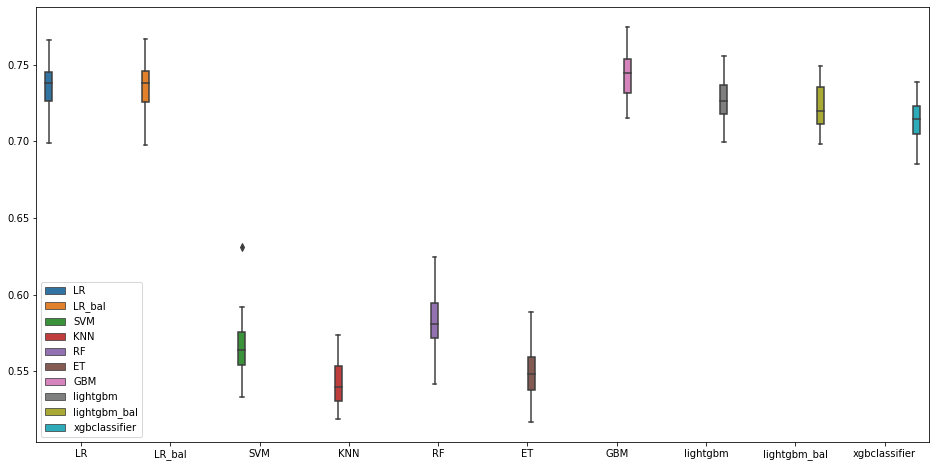

In [74]:
plt.figure(figsize = (16, 8))
sns.boxplot(y = results, x = names, hue = names)

Remember at this point we did not scale our data, its best tp first scale your data and get the results. Also, it is best to do this method on the training data so that the testing data is untouched.

Also, SVM('rbf') performed poorly and LR performed better so SVC('linear') can perform better here. For now, we will choose top models here.

- Logistic Regression
- GBM
- LGBM
- XGBoost

The Imbalanced Techniques are:

- Oversampling
- Undersampling
- Probability Tuning


>Oversampling/Undersampling generally do not work on the ensemble of trees
Also the resampling methods use KNearest Neighbors methods, so it is important to scale the data first

Probability tuning can be done with 
1. adjusting class weights(during training only as we have done here with some cases) or, 
2. we can set the probability threshold after the training and see the results


In [14]:
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from imblearn.pipeline import Pipeline

In [85]:
def get_models():
    models, names = list(), list()
    models.append(LogisticRegression(class_weight = 'balanced'))
    names.append('LRbalanced')
    #LDA
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    #SVM
    models.append(LinearSVC())
    names.append('SVM')
    #KNN
    models.append(KNeighborsClassifier())
    names.append('KNN')
    #GP
    models.append(GaussianProcessClassifier())
    names.append('GP')
    
    return models, names

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)
nm_hr = Normalizer()
nm_upp = Normalizer()
X_train['hour'] = nm_hr.fit_transform(np.array(X_train['hour']).reshape(-1,1))
X_train['user_past_purchases'] = nm_upp.fit_transform(np.array(X_train['user_past_purchases']).reshape(-1,1))



<ipython-input-6-b2ea1de354ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['hour'] = nm_hr.fit_transform(np.array(X_train['hour']).reshape(-1,1))
<ipython-input-6-b2ea1de354ea>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['user_past_purchases'] = nm_upp.fit_transform(np.array(X_train['user_past_purchases']).reshape(-1,1))


In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
models, names = get_models()
results = list()


for i in range(len(models)):

    steps = [('o', SMOTE(k_neighbors=2)), ('m', models[i])]
    pipeline = Pipeline(steps=steps)
    scores = evaluate_model(X_train, y_train, pipeline)
    results.append(scores)
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))

>LRbalanced 0.697 (0.015)
>LDA 0.697 (0.015)
>SVM 0.697 (0.015)


The KNN and GP failed to run on my local machine. But we see that rest of the models do not perform better with Oversampling.


In [20]:
from imblearn.under_sampling import NearMiss, RandomUnderSampler

steps1 = [('u', NearMiss(n_neighbors = 3)), ('m', LogisticRegression(class_weight = 'balanced'))]
pipeline1 = Pipeline(steps = steps1)
scores1 = evaluate_model(X_train, y_train, pipeline1)
name1 = 'LR with undersampling'
print('>%s %.3f (%.3f)' % (name1, mean(scores1), std(scores1)))


>LR with undersampling 0.501 (0.020)


In [24]:

steps2 = [('ro', RandomOverSampler()), ('m', LogisticRegression(class_weight = 'balanced'))]
pipeline2 = Pipeline(steps = steps2)
scores2 = evaluate_model(X_train, y_train, pipeline2)
name2 = 'LR with Random OverSampling'
print('>%s %.3f (%.3f)' % (name2, mean(scores2), std(scores2)))


>LR with Random OverSampling 0.696 (0.016)


In [25]:
from imblearn.under_sampling import  RandomUnderSampler

steps1 = [('ru', RandomUnderSampler()), ('m', LogisticRegression(class_weight = 'balanced'))]
pipeline1 = Pipeline(steps = steps1)
scores1 = evaluate_model(X_train, y_train, pipeline1)
name1 = 'LR with Randomundersampling'
print('>%s %.3f (%.3f)' % (name1, mean(scores1), std(scores1)))


>LR with Randomundersampling 0.696 (0.015)


In [26]:
steps1 = [('ro', RandomOverSampler()), ('ru', RandomUnderSampler()), ('m', LogisticRegression(class_weight = 'balanced'))]
pipeline1 = Pipeline(steps = steps1)
scores1 = evaluate_model(X_train, y_train, pipeline1)
name1 = 'LR with Randomundersampling'
print('>%s %.3f (%.3f)' % (name1, mean(scores1), std(scores1)))


>LR with Randomundersampling 0.697 (0.016)


Resampling methods are not quite working here

So, lets move forward with our non-imbalance algorithms. i.e, LR, LR(class_weight = 'balanced'), GBM, LGBM, XGBClassifier

In [127]:
# def roc_curve(y_test, y_pred):
#     fpr, tpr, thresholds = roc_curve(y_test, y_pred)
#     gmeans = np.sqrt(tpr * (1-fpr))
#     ix = np.argmax(gmeans)
#     print("Best Threshold", thresholds[ix], "Gmean: ", gmeans[ix])
#     ax = sns.lineplot(fpr, tpr, color = 'r')
#     plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#     ax.set_xlabel('FPR')
#     ax.set_ylabel('TPR')
    

Best Threshold 0.999988691514687 Gmean:  0.6492807023888072


Text(0, 0.5, 'TPR')

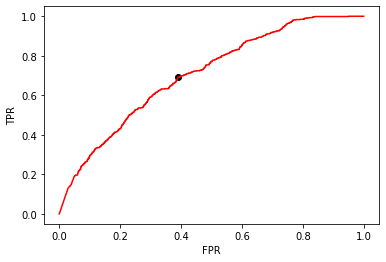

In [129]:


model = LogisticRegression(class_weight = 'balanced')

model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
y_pred = (y_pred[:, 1])

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print("Best Threshold", thresholds[ix], "Gmean: ", gmeans[ix])
ax = sns.lineplot(fpr, tpr, color = 'r')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')


Text(0.5, 33.0, 'Predicted Values')

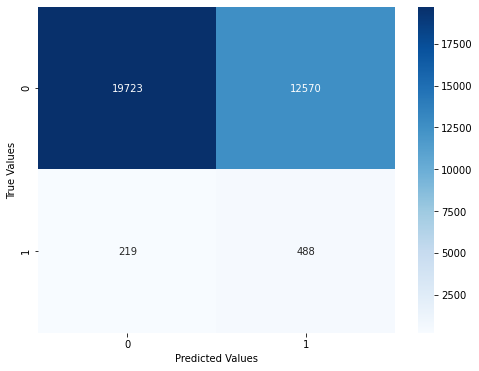

In [89]:
cm = confusion_matrix(y_test, y_pred>=thresholds[ix])

plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = 'Blues')
ax.set_ylabel('True Values')
ax.set_xlabel('Predicted Values')

In [111]:
new_sent = 488+12570
old_sent = 488+12570+19723+219
old_clicked = 219+488
new_clicked = 488
cost_fp = 1
cost_fn = 1
cost_sending = 1
fp = 12570
fn = 219

print('increase in click through rate:', round((new_clicked*100/(new_sent)) -  (old_clicked*100/(old_sent)), 2))
print("cost saving: ", cost_sending*(old_sent-new_sent)-cost_fp* fp - cost_fn*fn)

increase in click through rate: 1.59
cost saving:  7153


As we can see, even with all the costs set to 1, we are able to cost save and increase the CTR

Next step would be to fine tune the model by grid searching the parameters: C and class_weights

# Hyperparameter Tuning on Logistic Regression Classifier

In [121]:
c_values = [100, 10, 1.0, 0.1, 0.01]
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1', 'l2']

model = LogisticRegression()
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

In [122]:
grid_result.best_score_, grid_result.best_params_

(0.6960866294643854, {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'})

Best Threshold 0.9884449375977459 Gmean:  0.6488394382455407


Text(0.5, 33.0, 'Predicted Values')

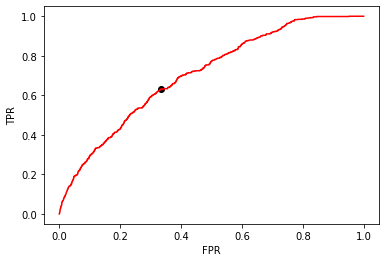

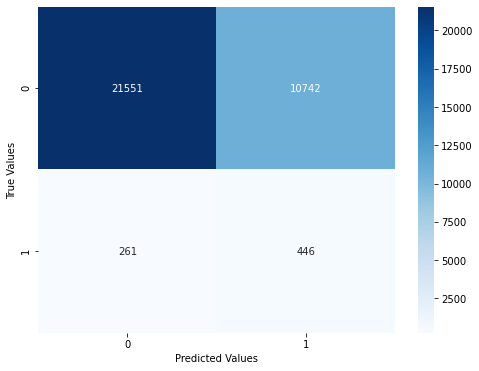

In [141]:
model = LogisticRegression(C = 0.1, penalty = 'l2', solver = 'lbfgs')

model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print("Best Threshold", thresholds[ix], "Gmean: ", gmeans[ix])
ax = sns.lineplot(fpr, tpr, color = 'r')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')


cm = confusion_matrix(y_test, y_pred>=thresholds[ix])

plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = 'Blues')
ax.set_ylabel('True Values')
ax.set_xlabel('Predicted Values')

In [142]:
new_sent = 446+10742
old_sent = 446+10742+21551+261
old_clicked = 261+446
new_clicked = 446
cost_fp = 1
cost_fn = 1
cost_sending = 1
fp = 10742
fn = 261

print('increase in click through rate:', round((new_clicked*100/(new_sent)) -  (old_clicked*100/(old_sent)), 2))
print("cost saving: ", cost_sending*(old_sent-new_sent)-cost_fp* fp - cost_fn*fn)

increase in click through rate: 1.84
cost saving:  10809


We were able to further better our model

Best Threshold 0.9999987748770033 Gmean:  0.6488103767582947


Text(0.5, 33.0, 'Predicted Values')

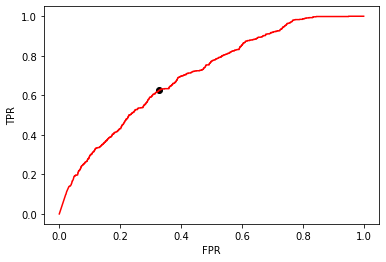

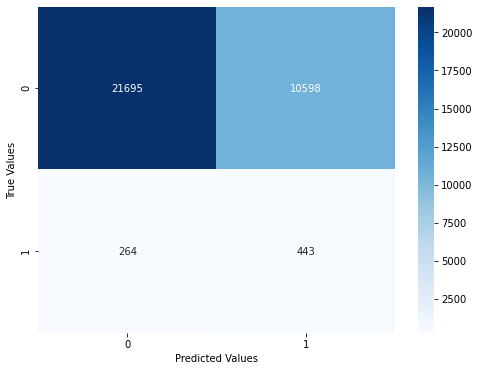

In [140]:
model = LogisticRegression(C = 0.1, penalty = 'l2', solver = 'lbfgs', class_weight = 'balanced')

model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print("Best Threshold", thresholds[ix], "Gmean: ", gmeans[ix])
ax = sns.lineplot(fpr, tpr, color = 'r')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')


cm = confusion_matrix(y_test, y_pred>=thresholds[ix])

plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = 'Blues')
ax.set_ylabel('True Values')
ax.set_xlabel('Predicted Values')

In [139]:
new_sent = 443+10598
old_sent = 443+10598+21695+264
old_clicked = 264+443
new_clicked = 443
cost_fp = 1
cost_fn = 1
cost_sending = 1
fp = 10598
fn = 264

print('increase in click through rate:', round((new_clicked*100/(new_sent)) -  (old_clicked*100/(old_sent)), 2))
print("cost saving: ", cost_sending*(old_sent-new_sent)-cost_fp* fp - cost_fn*fn)

increase in click through rate: 1.87
cost saving:  11097


With balanced class weights, we are able to increase the model performance even better.
We can perform GridSearch on the class weights as well and select the best model.


Next step would be to use GBM and see how much performance boost we could get!!

# Gradient Boost Classifier

In [143]:
?GradientBoostingClassifier

In [74]:
model =  GradientBoostingClassifier(learning_rate = 0.02, min_samples_split=500,min_samples_leaf=50,max_depth=8,
                                   max_features='sqrt',subsample=0.8,random_state=10)
grid = {'n_estimators':range(30,100,10)}
grid_search = GridSearchCV(estimator = model, param_grid = grid, 
                           scoring='roc_auc',n_jobs=-1, cv=5, verbose = True)

grid_result = grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   13.7s finished


In [75]:
grid_search.best_params_, grid_search.best_score_

({'n_estimators': 70}, 0.6948688349628492)

In [120]:
model =  GradientBoostingClassifier(learning_rate = 0.02,n_estimators=70,max_depth = 14, min_samples_leaf = 60,
                                    min_samples_split= 600, subsample = 0.8, 
                                   max_features='sqrt',random_state=10)

grid2 = {'max_features':[5,6,8, 10]}
grid_search = GridSearchCV(estimator = model, param_grid = grid2, 
                           scoring='roc_auc',n_jobs=-1, cv=5, verbose = True)

grid_result = grid_search.fit(X_train,y_train)
grid_search.best_params_, grid_search.best_score_


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   12.4s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   12.5s finished


**Let's make the functions for plotting the ROC curve and confusion matrix to avoid repeatation**

In [173]:
def plots(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    y_pred = (y_pred[:, 1])

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print("Best Threshold", thresholds[ix], "Gmean: ", gmeans[ix])
    ax = sns.lineplot(fpr, tpr, color = 'r')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')

    cm = confusion_matrix(y_test, y_pred>=0.024)
    cr = classification_report(y_test, y_pred>=0.024)

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = 'Blues')
    ax.set_ylabel('True Values')
    ax.set_xlabel('Predicted Values')
    return cm, cr

In [134]:
def results(confusion_matrix = cm):
    new_sent = cm[:, 1].sum()
    old_sent = cm.sum()
    old_clicked = cm[1, :].sum()
    new_clicked = cm[1, 1]
    cost_fp = 1
    cost_fn = 1
    cost_sending = 1
    fp = cm[0][1]
    fn = cm[1][0]
    
    ctr_inc= round((new_clicked*100/(new_sent)) -  (old_clicked*100/(old_sent)), 2)
    cost_save = cost_sending*(old_sent-new_sent)-cost_fp* fp - cost_fn*fn
    return ctr_inc, cost_save



Best Threshold 0.02413690733294398 Gmean:  0.6250983715517038


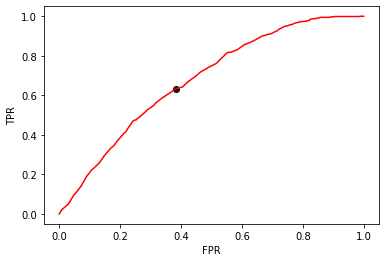

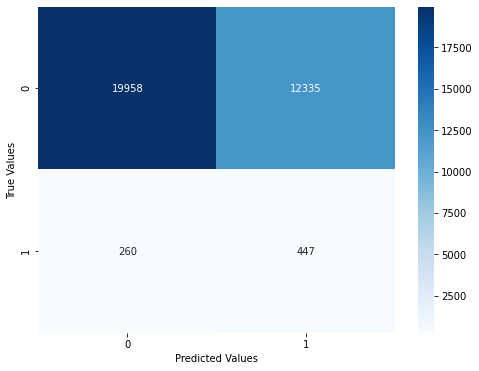

In [138]:
model = GradientBoostingClassifier(learning_rate = 0.02,n_estimators=70,max_depth = 14, min_samples_leaf = 60,
                                    min_samples_split= 600, subsample = 0.8, 
                                   max_features='sqrt',random_state=10)
cm, cr = plots(model, X_train, y_train, X_test, y_test)
ctr_inc, cost_save = results(cm)

In [133]:
print('increase in click through rate:',ctr_inc )
print("cost saving: ", cost_save)

increase in click through rate: 1.35
cost saving:  7623


In [146]:
ctr_inc, cost_save = results(cm)

print('increase in click through rate:',ctr_inc )
print("cost saving: ", cost_save)

increase in click through rate: 1.34
cost saving:  7095


In [148]:
pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False)

user_past_purchases           0.346040
email_version_personalized    0.202976
user_country_UK               0.091579
user_country_FR               0.083332
weekday_Wednesday             0.068000
user_country_US               0.058885
email_text_short_email        0.058612
weekday_Thursday              0.034412
weekday_Monday                0.024990
weekday_Tuesday               0.023552
weekday_Sunday                0.005341
weekday_Saturday              0.002282
hour                          0.000000
dtype: float64

# Feature Engineering


We can see that, the best gbm/LR model are not able to perform as expected; let us do some feature engineering and fit the models

1. We saw in our EDA that CTR was more for Weekdays in comparison to Weekends
2. CTR was more for english speaking countries UK, US than Fr and ES
3. CTR was more for short email text than long email text; similarly more for personalised than generic email.

Since hour does not seem to be importat at all, we will remove this.

In [149]:
email_data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,Opened,Clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


In [158]:
data = email_data.copy()

data['Weekday'] = data.weekday.apply(lambda x: 0 if x in ['Friday', 'Saturday', 'Sunday'] else 1)
data['english'] = data.user_country.apply(lambda x: 0 if x in ['FR', 'ES'] else 1)
data['email_text'] = data.email_text.apply(lambda x: 2 if x=='short_email' else 4)
data['email_version'] = data.email_version.apply(lambda x: 1 if x=='personalized' else 0)
data.drop(['email_id','hour', 'user_country','weekday'], inplace = True, axis =1)

In [159]:
data.head()

,email_text,email_version,user_past_purchases,Opened,Clicked,Weekday,english
0,2,1,5,0,0,0,1
1,4,1,2,1,1,0,1
2,4,1,2,0,0,1,1
3,2,0,1,0,0,1,1
4,4,0,6,0,0,1,1


In [160]:
X = data.drop(['Opened', 'Clicked'], axis = 1).copy()
y = data['Clicked']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

Best Threshold 0.022151172818562968 Gmean:  0.6701155795543979
increase in click through rate: 2.25
cost saving:  13023


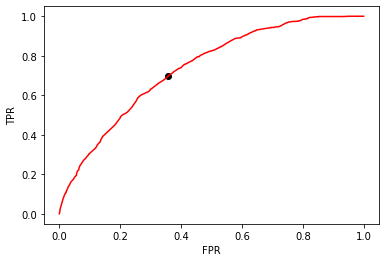

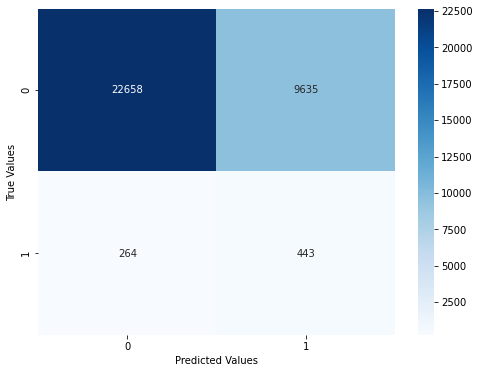

In [164]:
model = GradientBoostingClassifier()
cm = plots(model, X_train, y_train, X_test, y_test)

ctr_inc, cost_save = results(cm)

print('increase in click through rate:',ctr_inc )
print("cost saving: ", cost_save)

<AxesSubplot:>

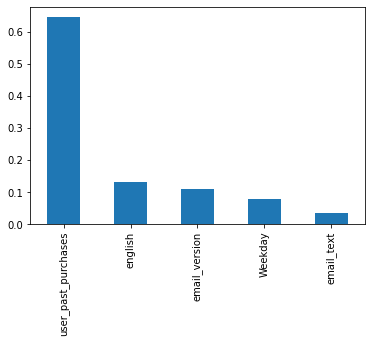

In [167]:
var_imp = pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False)
var_imp.plot(kind = 'bar', orientation = 'vertical')

As we can see, a little bit of feature engineering is resulting in a much more better prediction model!!


Best Threshold 0.0210150279974376 Gmean:  0.67996147368078
increase in click through rate: 2.51
cost saving:  14725


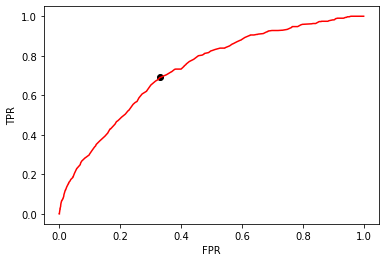

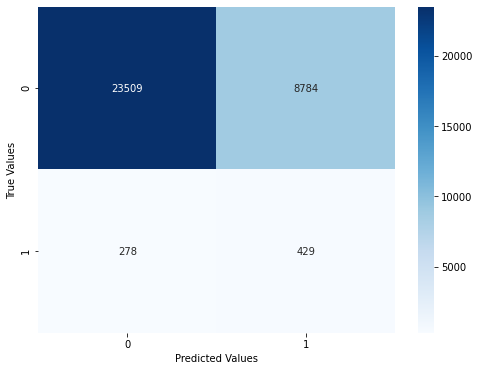

In [175]:
model = LogisticRegression()
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
cm, cr = plots(model, X_train, y_train, X_test, y_test)

ctr_inc, cost_save = results(cm)

print('increase in click through rate:',ctr_inc )
print("cost saving: ", cost_save)


In [177]:
print(cr)

              precision    recall  f1-score   support

           0       0.99      0.73      0.84     32293
           1       0.05      0.61      0.09       707

    accuracy                           0.73     33000
   macro avg       0.52      0.67      0.46     33000
weighted avg       0.97      0.73      0.82     33000



In [180]:
cm[1][1]/cm[:, 1].sum()

0.04656463692608271

In [181]:
import pickle

In [184]:
pickle.dump(model, open('finalised_model.sav', 'wb'))

In [185]:
filename = 'finalised_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [190]:
loaded_model.coef_

array([[-0.14755619,  0.31354836,  0.5776656 ,  0.25021406,  0.45633523]])

# Next Steps:


To test the conclusion, we need to perform an A/B test:

- randomly assign users to two groups, Control group and Experiment group.
- in Control group, still use the old email-campaign strategy, i.e., just send emails to all users in Control group.
- in Experiment group, use my model to predict whether the user will click the link or not. and only send emails to those users whose predictive result is positive.
- then we preform a one-tail unpaired t-test to test whether Experiement group's population proportion is higher than Control group's population proportion.